# 📊 Visualização da Simulação SAC

Este notebook apresenta a visualização gráfica de um financiamento simulado pelo sistema de amortização constante (SAC). Serão exibidos gráficos relacionados ao saldo devedor, à composição das parcelas e ao valor total pago mês a mês.

## 🔧 Configuração do Ambiente

Nesta célula, são importadas as bibliotecas necessárias e configurado o caminho para acesso ao código-fonte localizado na pasta `src/`.

In [9]:
# 📦 Imports necessários e configuração do path para src/
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Garante que a pasta src/ esteja no sys.path (assumindo estrutura SAD-FI/)
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Imports do projeto (arquitetura em camadas)
from domain.financiamento import Financiamento
from domain.simulador_sac import SimuladorSAC
# from domain.simulador_sac_ipca import SimuladorSAC_IPCA  # use quando for comparar IPCA


## 💰 Criação do Financiamento e Execução da Simulação

Simularemos um financiamento no valor total de R$ 100.000, com entrada de R$ 20.000, prazo de 12 meses e taxa de juros anual de 12%. A simulação retorna `SimulacaoResultado`.


In [10]:
# 💰 Criar um financiamento de exemplo e executar a simulação (SAC fixo)
financiamento = Financiamento(
    valor_total=100_000.0,
    entrada=20_000.0,
    prazo_anos=1,
    sistema='SAC'
)

# 🧠 Simular com taxa de juros de 12% ao ano
simulador = SimuladorSAC(financiamento, taxa_juros_anual=0.12)

# ⚠️ Agora o retorno é um SimulacaoResultado (não é lista de parcelas)
resultado = simulador.simular()

# Assert mínimo (TDD): 12 parcelas e totais positivos
assert len(resultado.parcelas) == 12
assert resultado.total_pago > 0 and resultado.total_juros > 0

print("Resumo:", resultado)
print("Dict:", resultado.to_dict_resumo())


Resumo: SimulacaoResultado(parcelas=12, total_pago=84934.17, total_juros=4934.17)
Dict: {'parcelas': 12, 'total_pago': 84934.17232598319, 'total_juros': 4934.172325983183}


## 📋 Conversão dos Dados para Tabela

Para facilitar a manipulação e visualização, as parcelas simuladas são convertidas para um `DataFrame` do pandas.

In [11]:
# 📋 Converter para DataFrame a partir de resultado.parcelas
dados = [{
    "Parcela": p.numero,
    "Amortização": p.amortizacao,
    "Juros": p.juros,
    "Valor Total": p.valor_total,
    "Saldo Devedor (antes)": p.saldo_devedor
} for p in resultado.parcelas]

df = pd.DataFrame(dados)

# Assert mínimo (TDD): colunas e tamanho esperados
cols_esperadas = {"Parcela","Amortização","Juros","Valor Total","Saldo Devedor (antes)"}
assert cols_esperadas.issubset(set(df.columns))
assert len(df) == 12

df.head()

,Parcela,Amortização,Juros,Valor Total,Saldo Devedor (antes)
0,1,6666.666667,759.103435,7425.770101,80000.000000
1,2,6666.666667,695.844815,7362.511482,73333.333333
2,3,6666.666667,632.586196,7299.252862,66666.666667
3,4,6666.666667,569.327576,7235.994243,60000.000000
4,5,6666.666667,506.068957,7172.735623,53333.333333


## 📉 Evolução do Saldo Devedor

Gráfico que mostra como o saldo devedor é reduzido ao longo do tempo. No SAC, ele reduz de forma linear devido à amortização constante.


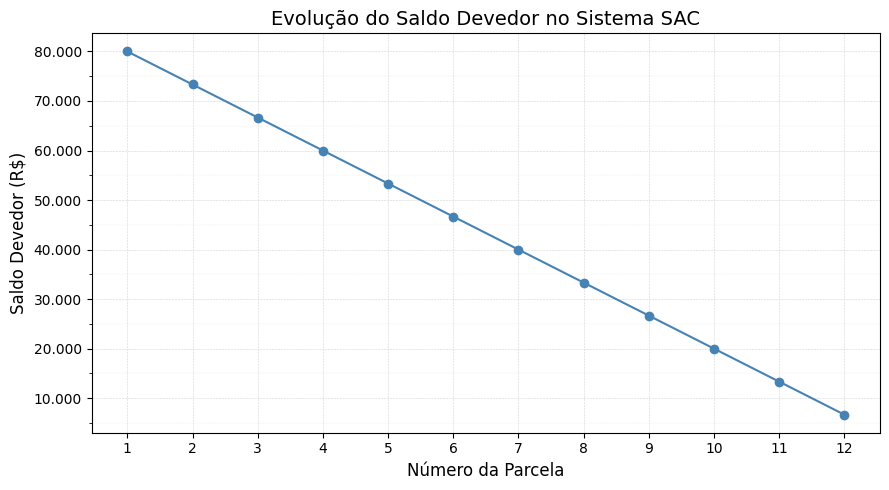

In [12]:
import matplotlib.ticker as ticker

plt.figure(figsize=(9, 5))

# Plot da linha
plt.plot(df['Parcela'], df['Saldo Devedor (antes)'], marker='o', color='steelblue')

# Título e rótulos
plt.title('Evolução do Saldo Devedor no Sistema SAC', fontsize=14)
plt.xlabel('Número da Parcela', fontsize=12)
plt.ylabel('Saldo Devedor (R$)', fontsize=12)

# Formatação de milhar com ponto (estilo brasileiro)
def formatar_reais(valor, pos):
    return f'{int(round(valor)):,}'.replace(',', '.')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(formatar_reais))

# Marcas no eixo Y (múltiplos de 10.000) e menores (a cada 5.000)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10000))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(5000))

# Todas as parcelas no eixo X
plt.xticks(df['Parcela'])

# Grades mais claras e finas
plt.grid(which='major', linestyle='--', linewidth=0.4, color='lightgray')
plt.grid(which='minor', linestyle=':', linewidth=0.3, color='lightgray')

plt.tight_layout()
plt.show()


## 📊 Composição da Parcela: Juros x Amortização

Neste gráfico, visualizamos como a parcela mensal é composta por duas partes: os juros (que decrescem com o tempo) e a amortização (que permanece constante).

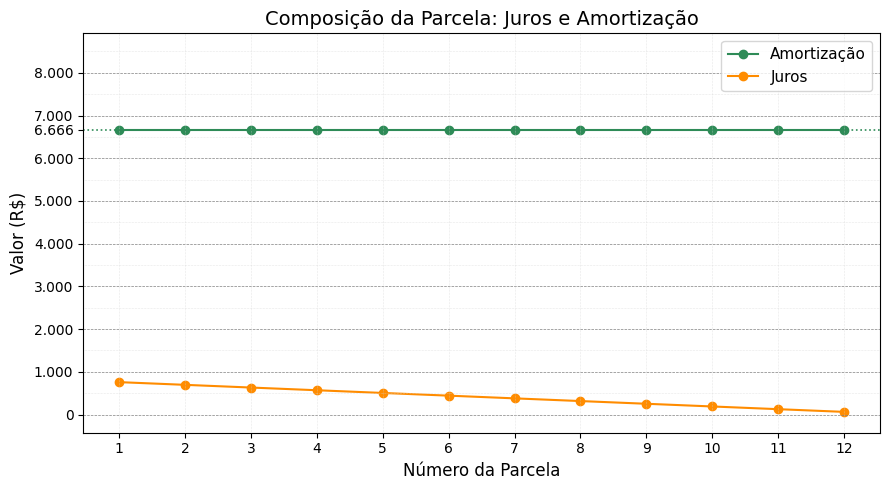

In [14]:
# 📊 Gráfico 2 – Juros vs Amortização
import matplotlib.ticker as ticker

# ✅ Verifica se as colunas necessárias estão no DataFrame
colunas_necessarias = {'Parcela', 'Amortização', 'Juros'}
if not colunas_necessarias.issubset(df.columns):
    raise ValueError(f"Colunas esperadas não encontradas no DataFrame. Colunas atuais: {df.columns.tolist()}")

plt.figure(figsize=(9, 5))

# Valor da amortização (constante)
valor_amortizacao = df['Amortização'].iloc[0]

# Determina limite superior do eixo Y
y_max = df[['Amortização', 'Juros']].values.max()
y_ticks_visiveis = list(range(0, int(y_max) + 2000, 1000))  # apenas os que terminam em 000

# Garante que a amortização apareça como tick visível
if int(valor_amortizacao) not in y_ticks_visiveis:
    y_ticks_visiveis.append(int(valor_amortizacao))
    y_ticks_visiveis = sorted(y_ticks_visiveis)

# Gera todos os ticks (500 em 500), mas só exibe os desejados
y_ticks_todos = list(range(0, int(y_max) + 2000, 500))
plt.yticks(y_ticks_visiveis)

# Formatador de milhar com ponto
def formatar_milhar(valor, pos):
    return f'{int(valor):,}'.replace(',', '.')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(formatar_milhar))

# Plot das curvas
plt.plot(df['Parcela'], df['Amortização'], label='Amortização', marker='o', color='seagreen')
plt.plot(df['Parcela'], df['Juros'], label='Juros', marker='o', color='darkorange')

# Título e rótulos
plt.title('Composição da Parcela: Juros e Amortização', fontsize=14)
plt.xlabel('Número da Parcela', fontsize=12)
plt.ylabel('Valor (R$)', fontsize=12)
plt.xticks(df['Parcela'])

# Grades horizontais: todas as de 500, mas só os rótulos de 1000 + amortização
for y in y_ticks_todos:
    if y % 1000 == 0:
        plt.axhline(y, linestyle='--', linewidth=0.5, color='gray')
    elif y % 500 == 0:
        plt.axhline(y, linestyle=':', linewidth=0.4, color='lightgray')

# Grade vertical para cada parcela
for x in df['Parcela']:
    plt.axvline(x, linestyle=':', linewidth=0.4, color='lightgray')

# Linha pontilhada destacando amortização
plt.axhline(valor_amortizacao, linestyle=':', linewidth=1.2, color='seagreen')

# Legenda
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()






## 💸 Valor Total da Parcela ao Longo do Tempo

Este gráfico mostra o valor total pago em cada parcela, que diminui ao longo do tempo no sistema SAC devido à redução dos juros.

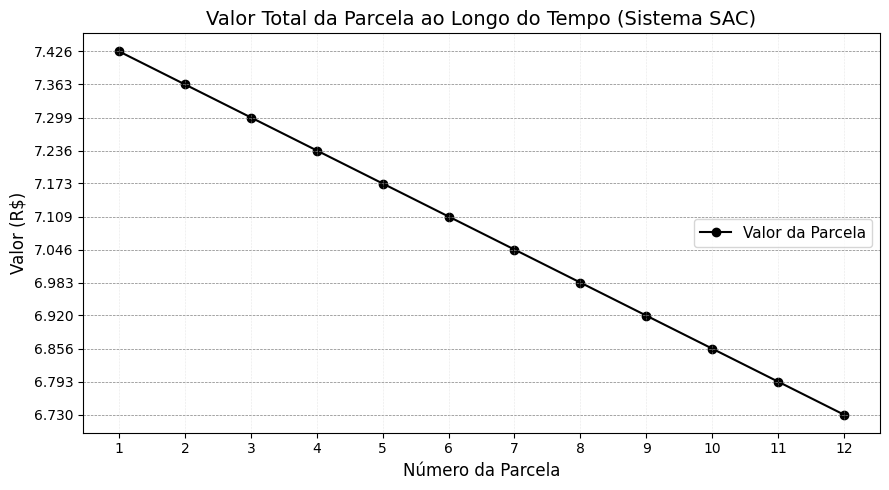

In [15]:
# 💸 Gráfico 3 – Valor Total da Parcela
import matplotlib.ticker as ticker

# ✅ Verifica se as colunas necessárias estão presentes
colunas_necessarias = {'Parcela', 'Valor Total'}
if not colunas_necessarias.issubset(df.columns):
    raise ValueError(f"Colunas esperadas não encontradas no DataFrame. Colunas atuais: {df.columns.tolist()}")

plt.figure(figsize=(9, 5))

# Extrai todos os valores distintos das parcelas (ordenados do maior para o menor)
valores_y = sorted(df['Valor Total'].unique(), reverse=True)
valores_y_int = [int(round(v)) for v in valores_y]

# Define os rótulos exatos no eixo Y
plt.yticks(valores_y_int)

# Formatador de milhar com ponto
def formatar_milhar(valor, pos):
    return f'{int(valor):,}'.replace(',', '.')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(formatar_milhar))

# Plot do gráfico
plt.plot(df['Parcela'], df['Valor Total'], color='black', marker='o', label='Valor da Parcela')

# Título e rótulos
plt.title('Valor Total da Parcela ao Longo do Tempo (Sistema SAC)', fontsize=14)
plt.xlabel('Número da Parcela', fontsize=12)
plt.ylabel('Valor (R$)', fontsize=12)
plt.xticks(df['Parcela'])

# Grades horizontais para cada valor da parcela
for y in valores_y_int:
    plt.axhline(y, linestyle='--', linewidth=0.5, color='gray')

# Grade vertical para cada parcela
for x in df['Parcela']:
    plt.axvline(x, linestyle=':', linewidth=0.4, color='lightgray')

# Legenda (opcional)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()




## ✅ Conclusão

A simulação confirma o comportamento esperado do sistema SAC. Os gráficos evidenciam a amortização constante, a queda dos juros e a consequente redução do valor total das parcelas ao longo do tempo.

---
# Fim da Sprint 1.
---
---

---
---
# O conteúdo a partir daqui veio da Sprint 2


## Calcular e exibir custo total de cada modalidade

Nesta etapa, implementa-se a função `exibir_comparacao_custos()`, que recebe dois objetos `SimulacaoResultado` e apresenta um **gráfico de barras** com o custo total (`total_pago`) de cada modalidade simulada.

O objetivo é:
- Visualizar de forma clara a diferença entre **SAC fixo** e **SAC IPCA+**.
- Destacar a modalidade mais econômica diretamente no gráfico.
- Fornecer, no console, um **resumo numérico** com economia absoluta e relativa.

A metodologia segue a filosofia **TDD**:
1. Criar a função de visualização de forma isolada.
2. Testar a função usando dados controlados (IPCA fixo de 0,5% a.m.).
3. Garantir que os valores sejam coerentes e o gráfico seja gerado corretamente.
4. Exibir também a **mensagem de comparação** e a **recomendação final** para contextualizar o gráfico.

Na primeira célula, é definida a função `exibir_comparacao_custos()` com comentários explicativos.  
Na segunda célula, realizamos o teste prático integrando o `ControladorApp` para gerar os resultados e alimentar a visualização.


## Função de visualização

In [16]:
# --- Visualização comparativa de custos (SAC fixo vs SAC IPCA+) ---
# Mantém o padrão de comentários usado no projeto.

from matplotlib import pyplot as plt

def _fmt_brl(valor: float) -> str:
    """
    Formata número em estilo 'R$ 1.234.567,89' sem depender de locale do SO.
    """
    s = f"{valor:,.2f}"
    return "R$ " + s.replace(",", "X").replace(".", ",").replace("X", ".")

def exibir_comparacao_custos(resultado1, resultado2, nomes=("SAC fixo", "SAC IPCA+"), titulo="Comparação de custo total"):
    """
    Exibe gráfico de barras com o custo total (total_pago) de duas modalidades.

    Parâmetros:
    - resultado1, resultado2: objetos SimulacaoResultado
    - nomes (tuple[str, str]): rótulos para cada modalidade no eixo X
    - titulo (str): título do gráfico

    Saída:
    - Gráfico matplotlib exibido inline e impressão de um resumo numérico.
    """
    # Extrai os totais pagos de cada simulação
    totais = [resultado1.total_pago, resultado2.total_pago]

    # Determina qual é o menor custo para destacar na anotação
    idx_min = 0 if totais[0] <= totais[1] else 1

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(6, 4))
    barras = ax.bar(range(2), totais)

    # Rótulos e título
    ax.set_title(titulo)
    ax.set_xticks([0, 1], nomes)
    ax.set_ylabel("Custo total (R$)")

    # Anota valores no topo das barras
    for i, b in enumerate(barras):
        altura = b.get_height()
        ax.text(
            b.get_x() + b.get_width()/2,
            altura,
            _fmt_brl(altura),
            ha="center",
            va="bottom"
        )

    # Anota destaque textual na barra mais barata
    ax.text(
        barras[idx_min].get_x() + barras[idx_min].get_width()/2,
        barras[idx_min].get_height()*1.02,
        "Menor custo",
        ha="center",
        va="bottom",
        fontweight="bold"
    )

    plt.tight_layout()
    plt.show()

    # --- Resumo numérico no console (útil para o relatório/prints) ---
    print("Resumo numérico:")
    print(f" - {nomes[0]}: {_fmt_brl(totais[0])}")
    print(f" - {nomes[1]}: {_fmt_brl(totais[1])}")
    economia = abs(totais[0] - totais[1])
    base = min(totais)
    perc = (economia / base * 100) if base > 0 else 0.0
    print(f" - Economia absoluta: {_fmt_brl(economia)}")
    print(f" - Economia relativa: {perc:.2f}%")


## Teste rápido (TDD) da visualização usando o ControladorApp

In [ ]:
import os
from application.controlador import ControladorApp
from presentation.visualizacao import exibir_comparacao_custos  # ajuste para seu local real

# 📂 Caminho absoluto para o arquivo de IPCA fixo
caminho_ipca_fixo = os.path.abspath(os.path.join("dados", "ipca_fixo.csv"))

# 📌 Dados para simulação SAC fixo
dados_sac = {
    "valor_total": 300000.0,
    "entrada": 20000.0,
    "prazo_anos": 5,
    "sistema": "SAC",
    "taxa_juros_anual": 0.06
}

# 📌 Dados para simulação SAC IPCA+
dados_ipca = {
    "valor_total": 300000.0,
    "entrada": 20000.0,
    "prazo_anos": 5,
    "sistema": "SAC_IPCA",
    "caminho_ipca": caminho_ipca_fixo
}

print("🔧 Iniciando teste de visualização com ControladorApp...")

# ▶️ Executa simulações
app = ControladorApp()
res_sac = app.executar_simulacao(dados_sac)
res_ipca = app.executar_simulacao(dados_ipca)

# 🧪 Asserts mínimos (TDD)
assert res_sac.total_pago > 0 and res_ipca.total_pago > 0, "Valores inválidos nos resultados."

# 📊 Exibe gráfico de comparação de custos
exibir_comparacao_custos(res_sac, res_ipca)

print("✅ Teste de visualização executado com sucesso.")



FileNotFoundError: [Errno 2] No such file or directory: 'dados/ipca_fixo.csv'